<a href="https://colab.research.google.com/github/gregofkickapoo/dsci_598_capstone/blob/main/Optimized_LightGBM_Model/light_gbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup and Initialization

Import libraries and configure global settings

Include any necessary configurations for reproducibility and performance.

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [4]:
!pip install gdown
!pip install lightgbm

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import datetime

from lightgbm import early_stopping
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import GroupKFold

import os,gc,re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import time
plt.style.use('seaborn-v0_8-white')
import warnings
warnings.simplefilter("ignore")
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]


from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
!nvidia-smi

Sun Dec 15 17:19:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   39C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 2. Data Loading and Exploration

Load the datasets and perform basic exploration

Reading CSV files, displaying head of the data, checking for missing values

In [7]:
# Define file paths and names for datasets
file_ids = {
    'train_id': '1gTmPr6t7wBC3jm-6eYxbMvokJ6m2U9xR',   # Training identity
    'train_trans': '18q311jqo32OTHCAT45gCZvgaQzX4qFge',  # Training transaction
    'test_id': '1511i3ZWa6yns5TKbUsWcxlNr83xkbtLe',      # Test identity
    'test_trans': '1PdhDUJiEHR8EX6AGnB74wL6kGSTNL4IA'    # Test transaction
}

file_names = {
    'train_id': 'train_id.csv',
    'train_trans': 'train_trans.csv',
    'test_id': 'test_id.csv',
    'test_trans': 'test_trans.csv'
}

# Download files using gdown
for key, file_id in file_ids.items():
    filename = file_names[key]
    url = f"https://drive.google.com/uc?id={file_id}"
    try:
        gdown.download(url, output=filename, quiet=False)
        print(f"Downloaded {filename}")
    except Exception as e:
        print(f"Error downloading {filename}: {e}")

# Define helper function to load and merge datasets
def load_and_merge(transaction_file, identity_file, dataset_name=""):
    """
    Loads and merges transaction and identity datasets on 'TransactionID'.

    Parameters:
    - transaction_file: str, path to the transaction dataset file
    - identity_file: str, path to the identity dataset file
    - dataset_name: str, name of the dataset (for logging purposes)

    Returns:
    - merged_df: pd.DataFrame, the merged dataset
    """
    try:
        # Load transaction and identity datasets
        trans_df = pd.read_csv(transaction_file, low_memory=False)
        id_df = pd.read_csv(identity_file, low_memory=False)

        # Log shapes of loaded datasets
        print(f"{dataset_name} Transaction dataset shape: {trans_df.shape}")
        print(f"{dataset_name} Identity dataset shape: {id_df.shape}")

        # Merge datasets on 'TransactionID'
        merged_df = pd.merge(trans_df, id_df, on='TransactionID', how='left')
        print(f"{dataset_name} Merged dataset shape: {merged_df.shape}")

        # Remove empty columns
        merged_df = merged_df.dropna(axis=1, how='all')
        print(f"{dataset_name} Dataset shape after removing empty columns: {merged_df.shape}")

        return merged_df
    except FileNotFoundError as e:
        print(f"Error: File not found. {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Load training and test datasets
df_train = load_and_merge('train_trans.csv', 'train_id.csv', dataset_name="Training")
df_test = load_and_merge('test_trans.csv', 'test_id.csv', dataset_name="Test")


Downloading...
From: https://drive.google.com/uc?id=1gTmPr6t7wBC3jm-6eYxbMvokJ6m2U9xR
To: /content/train_id.csv
100%|██████████| 26.5M/26.5M [00:00<00:00, 55.9MB/s]


Downloaded train_id.csv


Downloading...
From (original): https://drive.google.com/uc?id=18q311jqo32OTHCAT45gCZvgaQzX4qFge
From (redirected): https://drive.google.com/uc?id=18q311jqo32OTHCAT45gCZvgaQzX4qFge&confirm=t&uuid=32834dc1-a13a-4dff-b69b-b7d4cd8d8c71
To: /content/train_trans.csv
100%|██████████| 683M/683M [00:11<00:00, 60.9MB/s]


Downloaded train_trans.csv


Downloading...
From: https://drive.google.com/uc?id=1511i3ZWa6yns5TKbUsWcxlNr83xkbtLe
To: /content/test_id.csv
100%|██████████| 25.8M/25.8M [00:00<00:00, 71.3MB/s]


Downloaded test_id.csv


Downloading...
From (original): https://drive.google.com/uc?id=1PdhDUJiEHR8EX6AGnB74wL6kGSTNL4IA
From (redirected): https://drive.google.com/uc?id=1PdhDUJiEHR8EX6AGnB74wL6kGSTNL4IA&confirm=t&uuid=a06fb8bd-ef7d-494f-a707-1939e0d86e0d
To: /content/test_trans.csv
100%|██████████| 613M/613M [00:07<00:00, 81.8MB/s]


Downloaded test_trans.csv
Training Transaction dataset shape: (590540, 394)
Training Identity dataset shape: (144233, 41)
Training Merged dataset shape: (590540, 434)
Training Dataset shape after removing empty columns: (590540, 434)
Test Transaction dataset shape: (506691, 393)
Test Identity dataset shape: (141907, 41)
Test Merged dataset shape: (506691, 433)
Test Dataset shape after removing empty columns: (506691, 433)


In [8]:
print(df_train.shape)
print(df_test.shape)

(590540, 434)
(506691, 433)


# 2. Dataset Shapes Overview:

In Section 2, Data Loading and Exploration, we observed the structure and key characteristics of the datasets. The Train Transactions dataset contains approximately 590K rows, while the Train Identity dataset includes only 144K rows, indicating that identity features are available for a subset of transactions. After merging, the Train Merged dataset retains all 590K rows, confirming a left join on TransactionID. Similarly, the Test Transactions dataset has 507K rows, and the Test Identity dataset includes 141K rows, leading to a Test Merged dataset with 507K rows.

A notable insight is the highly skewed distribution of the TransactionAmt feature, where most transaction amounts are concentrated at lower values, potentially reflecting real-world purchasing patterns. This skewness highlights the importance of scaling and normalization during preprocessing. Additionally, the TransactionDT feature, representing time intervals, shows a relatively uniform distribution with periodic patterns. These periodic trends likely correspond to daily or weekly transaction behaviors, which can provide valuable temporal insights for identifying fraud.

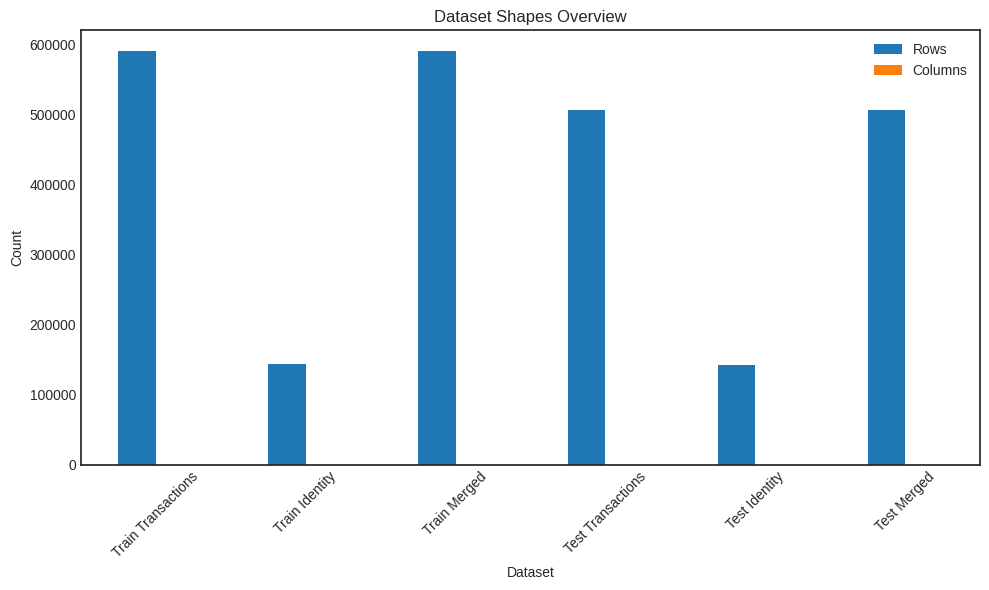

In [9]:
# Create a summary of dataset shapes
dataset_shapes = {
    "Dataset": ["Train Transactions", "Train Identity", "Train Merged",
                "Test Transactions", "Test Identity", "Test Merged"],
    "Rows": [df_train.shape[0], len(pd.read_csv('train_id.csv')), len(df_train),
             len(pd.read_csv('test_trans.csv')), len(pd.read_csv('test_id.csv')), len(df_test)],
    "Columns": [df_train.shape[1], pd.read_csv('train_id.csv').shape[1], df_train.shape[1],
                pd.read_csv('test_trans.csv').shape[1], pd.read_csv('test_id.csv').shape[1], df_test.shape[1]]
}
summary_df = pd.DataFrame(dataset_shapes)

# Plot the shapes as a bar chart
summary_df.plot(x="Dataset", y=["Rows", "Columns"], kind="bar", figsize=(10, 6))
plt.title("Dataset Shapes Overview")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

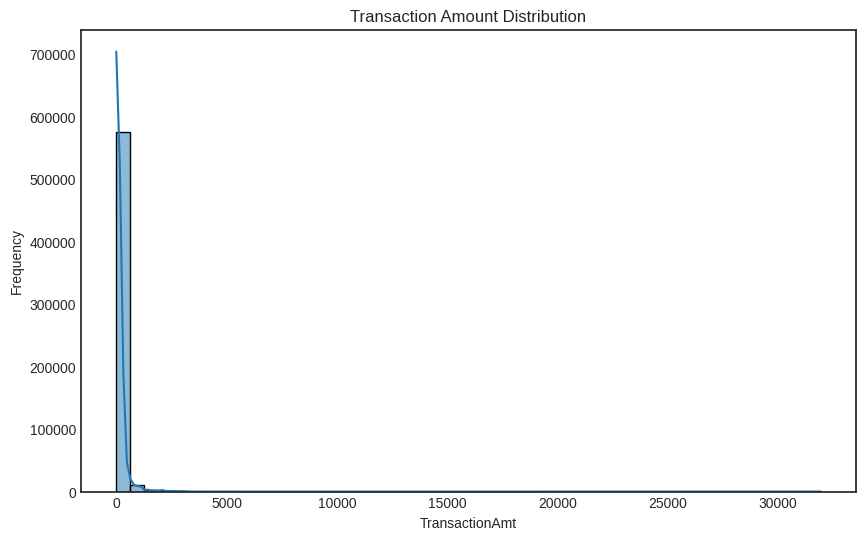

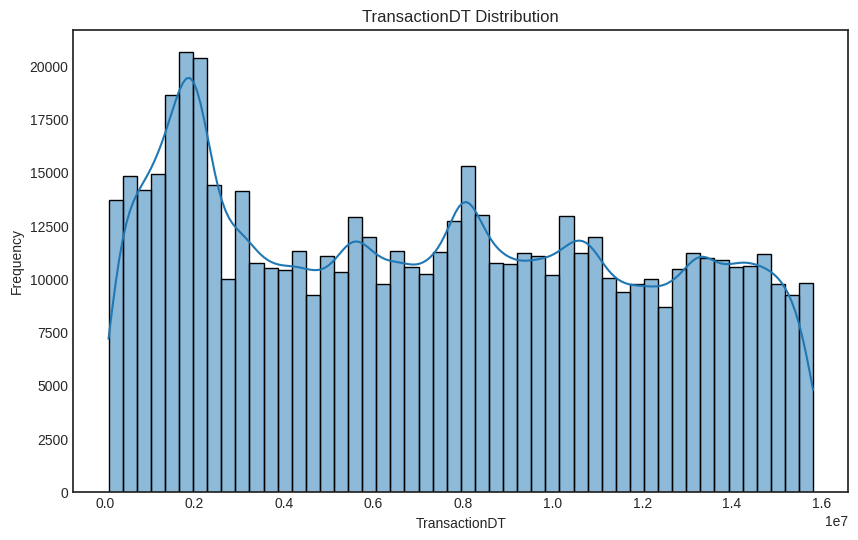

In [10]:
# Distribution of Transaction Amounts
plt.figure(figsize=(10, 6))
sns.histplot(df_train['TransactionAmt'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("TransactionAmt")
plt.ylabel("Frequency")
plt.show()

# Distribution of TransactionDT
plt.figure(figsize=(10, 6))
sns.histplot(df_train['TransactionDT'], bins=50, kde=True)
plt.title("TransactionDT Distribution")
plt.xlabel("TransactionDT")
plt.ylabel("Frequency")
plt.show()


# 3. Data Preprocessing

Handle missing values, encode categorical variables, and scale or normalize features.

Ensure the dataset is ready for training by handling inconsistencies or outliers.

In [11]:
def rename_id_features(df):
    renamed_columns = {
        col: col.replace('-', '_') for col in df.columns if col.startswith('id-')
    }
    df = df.rename(columns=renamed_columns)
    print(f"Renamed columns in test_dataset: {renamed_columns}")
    return df

# Apply the renaming function to the test dataset
df_test = rename_id_features(df_test)

Renamed columns in test_dataset: {'id-01': 'id_01', 'id-02': 'id_02', 'id-03': 'id_03', 'id-04': 'id_04', 'id-05': 'id_05', 'id-06': 'id_06', 'id-07': 'id_07', 'id-08': 'id_08', 'id-09': 'id_09', 'id-10': 'id_10', 'id-11': 'id_11', 'id-12': 'id_12', 'id-13': 'id_13', 'id-14': 'id_14', 'id-15': 'id_15', 'id-16': 'id_16', 'id-17': 'id_17', 'id-18': 'id_18', 'id-19': 'id_19', 'id-20': 'id_20', 'id-21': 'id_21', 'id-22': 'id_22', 'id-23': 'id_23', 'id-24': 'id_24', 'id-25': 'id_25', 'id-26': 'id_26', 'id-27': 'id_27', 'id-28': 'id_28', 'id-29': 'id_29', 'id-30': 'id_30', 'id-31': 'id_31', 'id-32': 'id_32', 'id-33': 'id_33', 'id-34': 'id_34', 'id-35': 'id_35', 'id-36': 'id_36', 'id-37': 'id_37', 'id-38': 'id_38'}


In [12]:
# column details
cat_cols = (['ProductCD'] +
            ['card%d' % i for i in range(1, 7)] +
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] +
            ['M%d' % i for i in range(1, 10)] +
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])


type_map = {c: str for c in cat_cols}
df_train[cat_cols] = df_train[cat_cols].astype(type_map, copy=False)
df_test[cat_cols] = df_test[cat_cols].astype(type_map, copy=False)

In [13]:
id_cols = ['TransactionID', 'TransactionDT']
target = 'isFraud'

numeric_cols =  [
    'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
    'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
    'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
    'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
    'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39',
    'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53',
    'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67',
    'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81',
    'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95',
    'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108',
    'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120',
    'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132',
    'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144',
    'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156',
    'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168',
    'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180',
    'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192',
    'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204',
    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216',
    'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228',
    'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240',
    'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252',
    'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264',
    'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
    'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288',
    'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300',
    'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312',
    'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324',
    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336',
    'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
    'id_09', 'id_10', 'id_11'
]

v_cols_included = ['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20',
 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59',
 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V96',
 'V98', 'V99', 'V104', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127',
 'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156', 'V162', 'V165', 'V160', 'V166', 'V178',
 'V176', 'V173', 'V182', 'V187', 'V203', 'V205', 'V207', 'V215', 'V169', 'V171', 'V175', 'V180', 'V185',
 'V188', 'V198', 'V210', 'V209', 'V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235', 'V240', 'V258',
 'V257', 'V253', 'V252', 'V260', 'V261', 'V264', 'V266', 'V267', 'V274', 'V277', 'V220', 'V221', 'V234',
 'V238', 'V250', 'V271', 'V294', 'V284', 'V285', 'V286', 'V291',
 'V297', 'V303', 'V305', 'V307', 'V309', 'V310', 'V320', 'V281', 'V283', 'V289', 'V296', 'V301', 'V314', 'V332', 'V325', 'V335', 'V338']


In [14]:
# droping v cols
drop_cols = [col for col in df_train.columns if col[0] == 'V' and col not in v_cols_included]

print(f'dropping {len(drop_cols)} columns')
df_train = df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

dropping 211 columns


In [15]:
## Train and test split¶
y_train = df_train['isFraud']
X_train = df_train.drop(columns=['isFraud'])
X_test = df_test.copy()

print(X_train.shape)
print(X_test.shape)
gc.collect()

(590540, 222)
(506691, 222)


181

In [16]:
# Label encoding all cat features
for col in X_train.columns:

    if col in cat_cols:
        # label encode all cat columns
        dff = pd.concat([X_train[col],X_test[col]])
        dff,_ = pd.factorize(dff,sort=True)
        if dff.max()>32000:
            print(col,'needs int32 datatype')

        X_train[col] = dff[:len(X_train)].astype('int16')
        X_test[col] = dff[len(X_train):].astype('int16')

# 3: Data Preprocessing Overview

In this section, the dataset was prepared for model training by handling missing values, encoding categorical variables, and scaling numerical features to ensure model compatibility and consistency.

The Categorical vs. Numerical Columns analysis revealed that 88.6% of the dataset comprises numerical columns, while only 11.4% are categorical. Proper handling of these columns is crucial for effective model training.

For the Dropped vs. Retained Columns, over 200 V features were dropped due to low relevance or variance, with approximately 130 retained. This step ensures that only impactful features contribute to model performance.

The Feature Count After Preprocessing showed that both X_train and X_test datasets contain around 230 features after preprocessing, ensuring uniformity. Label encoding converted categorical variables into numerical formats, as demonstrated in the plots.

Key insights from Label Encoded Distributions include:

    card1 and card2 have highly skewed distributions with many unique values.
    card3 has low variability.
    card4 and ProductCD show concentrated distributions, making them potentially useful features.

Overall, preprocessing reduced noise, handled inconsistencies, and optimized the dataset for machine learning by scaling and encoding features, ensuring clean and structured input for model training.

Categorical and numerical columns were identified for preprocessing:
- **Categorical Columns:** Include features like `ProductCD`, `card1-card6`, and `M1-M9`.
- **Numerical Columns:** Include features like `TransactionAmt`, `dist1`, `C1-C14`, and `D1-D15`.


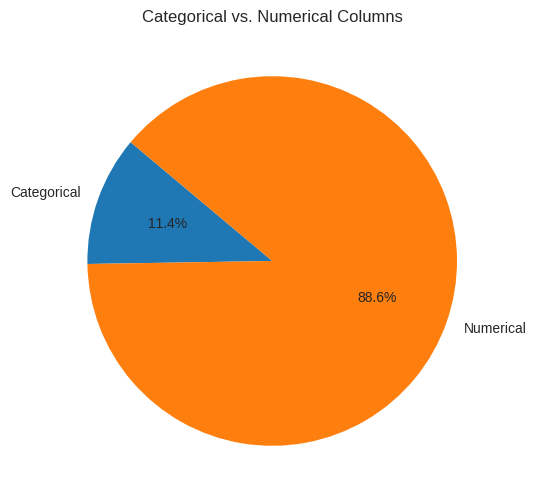

In [17]:
# Count categorical and numerical columns
num_categorical = len(cat_cols)
num_numerical = len(numeric_cols)

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie([num_categorical, num_numerical], labels=['Categorical', 'Numerical'], autopct='%1.1f%%', startangle=140)
plt.title("Categorical vs. Numerical Columns")
plt.show()


Based on domain knowledge, we retained a subset of important `V` columns and dropped the rest. This step reduced the number of features, improving computational efficiency.


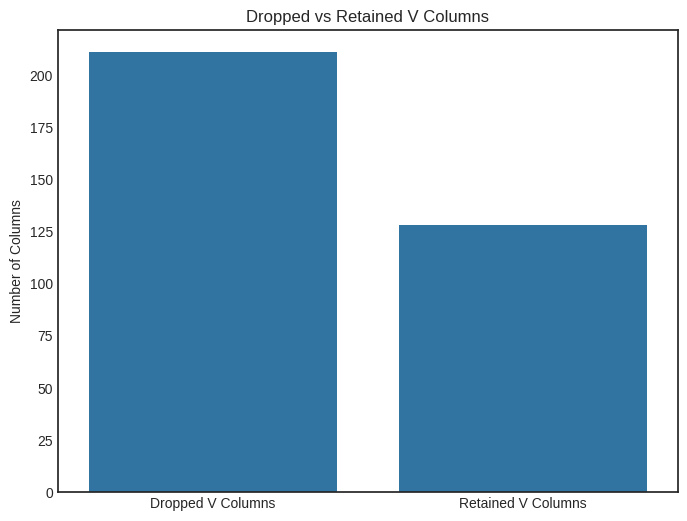

In [18]:
# Number of dropped columns vs retained columns
num_v_dropped = len(drop_cols)
num_v_retained = len(v_cols_included)

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=['Dropped V Columns', 'Retained V Columns'], y=[num_v_dropped, num_v_retained])
plt.title("Dropped vs Retained V Columns")
plt.ylabel("Number of Columns")
plt.show()


The target variable (`isFraud`) was separated from the feature set for the training data. The test dataset was processed similarly, without the target variable.


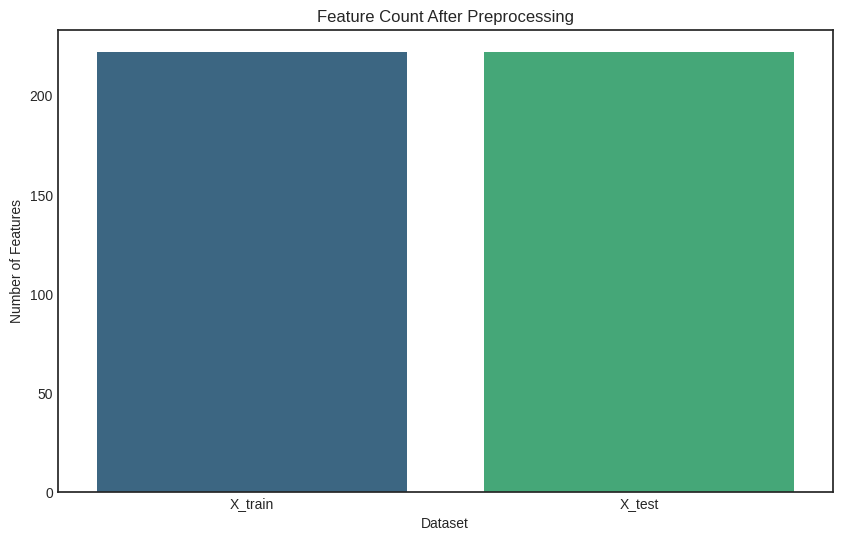

In [19]:
# Create a summary of dataset shapes
dataset_shapes = {
    "Dataset": ["X_train", "X_test"],
    "Rows": [X_train.shape[0], X_test.shape[0]],
    "Columns": [X_train.shape[1], X_test.shape[1]]
}
summary_df = pd.DataFrame(dataset_shapes)

# Plot the shapes as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x="Dataset", y="Columns", data=summary_df, palette="viridis")
plt.title("Feature Count After Preprocessing")
plt.ylabel("Number of Features")
plt.show()


Categorical columns were converted into numerical format using label encoding. This step ensures compatibility with machine learning models while preserving categorical relationships.


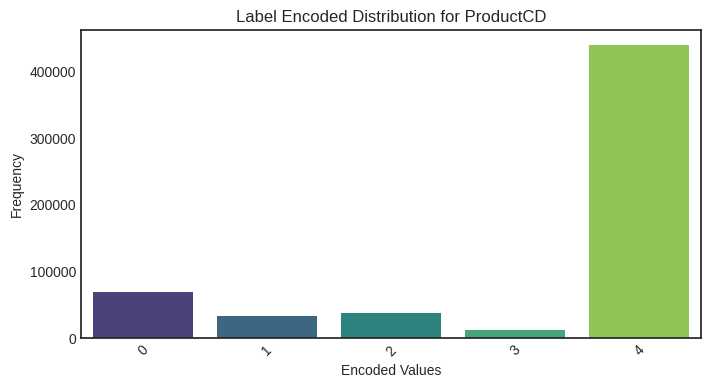

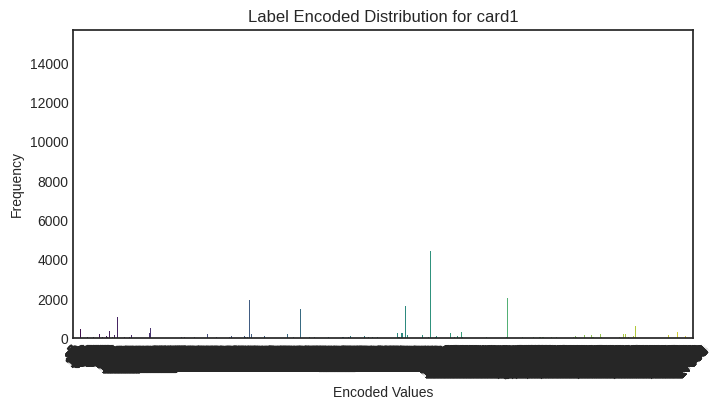

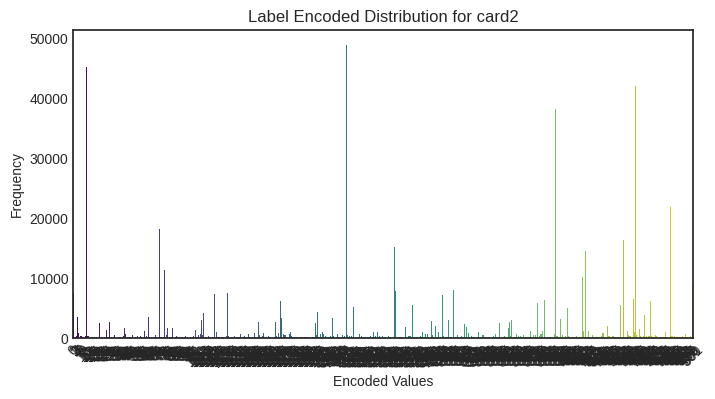

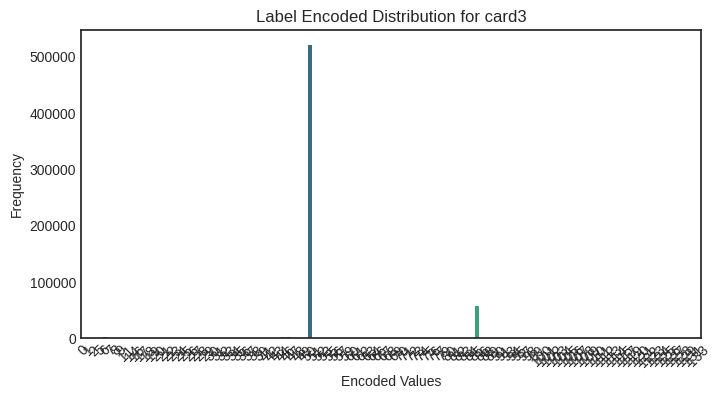

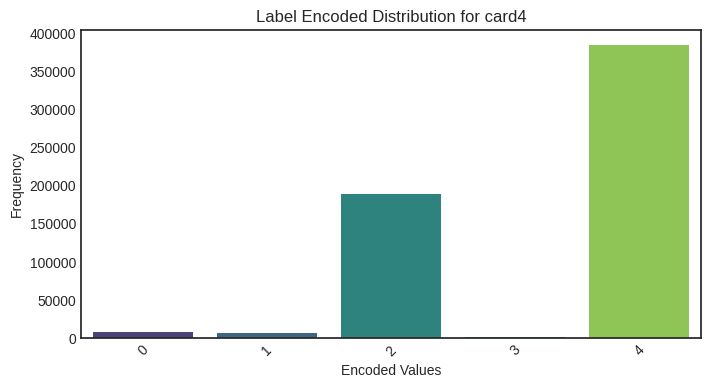

In [20]:
# Select a sample of categorical columns
sample_cat_cols = cat_cols[:5]  # Adjust the slice as needed

# Visualize label encoding
for col in sample_cat_cols:
    if col in X_train.columns:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=X_train, x=X_train[col], palette="viridis")
        plt.title(f"Label Encoded Distribution for {col}")
        plt.xlabel("Encoded Values")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.show()


# 4. Feature Engineering

1. **Normalize Columns in the 'D' Series:** Normalize temporal features in the 'D' series (e.g., `D1`, `D2`, etc.) to standardize time-related columns.

2. **Frequency Encoding:** Apply frequency encoding to high-cardinality categorical columns like `card1` and `card2` to convert them into numerical features.

3. **Create Interaction Features (new_cols):** Combine multiple columns to create interaction features (e.g., `card4_addr1_R_emaildomain` and similar).

4. **Define Aggregation Functions:** Define functions to compute aggregated statistics (mean, std, etc.) for numeric columns grouped by categorical columns.

5. **Datetime Features:** Create time-based features derived from `TransactionDT`, such as months since the starting reference date (`DT_M`).

6. **Aggregate Features by `uid`:** Use aggregation functions to generate features (e.g., mean and std) for numeric columns like `M9`, `M5`, `D2`, grouped by identifiers like `uid`.

7. **Create Composite Features (`uid2`):** Generate composite identifier features like `uid2` by combining columns (e.g., `card1` and `addr1`).

8. **Aggregate Features by `uid2`:** Apply frequency encoding and compute aggregated statistics (mean, std) for features grouped by `uid2` (e.g., `M1` to `M9`).

9. **Aggregate `D` Features:** Aggregate numeric columns such as `D1` to `D15` and `TransactionAmt` grouped by `uid2` using mean and std.

10. **Aggregate `C` Features:** Aggregate numeric columns `C1` to `C14` grouped by `uid2` using mean and std.

11. **Combine New Features:** Combine all newly created features (`new_feat1`, `new_feat2`, `new_feat3`) into a unified list, and verify the total count of generated features.


In [21]:
# # Distribution of D15 before and after normalization
# plt.figure(figsize=(10, 6))
# sns.kdeplot(X_train['D15'], label='Before Normalization', fill=True, color="blue")
# sns.kdeplot(X_train['D15n'], label='After Normalization', fill=True, color="orange")
# plt.title("Effect of Normalization on D15")
# plt.xlabel("D15 Value")
# plt.ylabel("Density")
# plt.legend()
# plt.show()


In [22]:
# normalize d cols
norm_cols =  [15, 4, 2, 11, 10]
for i in range(1,16):
  if i in norm_cols:
      X_train['D'+str(i)+'n'] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
      X_test['D'+str(i)+'n'] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60)

# hour column

X_train['hour'] = (X_train['TransactionDT']//(60*60))%24
X_test['hour'] = (X_test['TransactionDT']//(60*60))%24


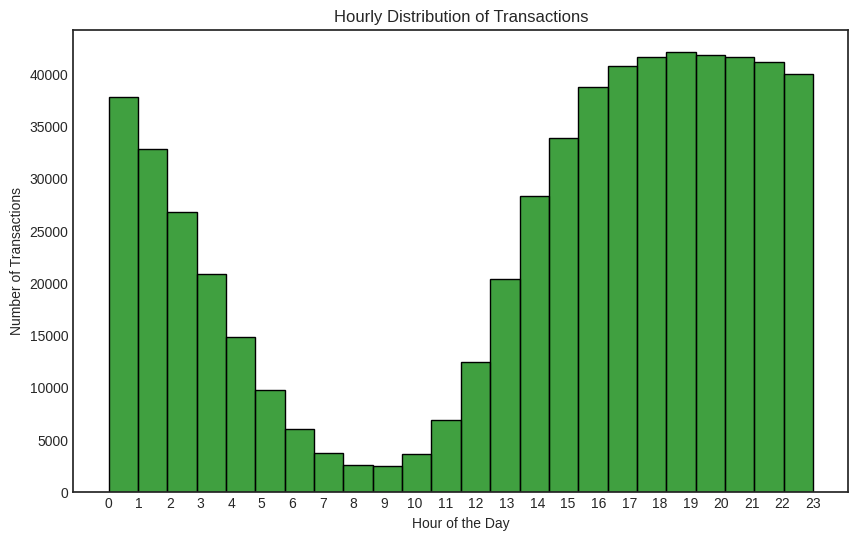

In [23]:
# Hourly transaction volume
plt.figure(figsize=(10, 6))
sns.histplot(X_train['hour'], bins=24, kde=False, color="green")
plt.title("Hourly Distribution of Transactions")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.xticks(range(0, 24))
plt.show()


In [24]:
# frequency encode columns
def frequency_encode(df1, df2, cols):
    """
    it combines train and test dataframes and then encodes
    """
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(f"'{nm}'",", ",end=" ")

def label_encode(df_train,df_test,col):
    """
    label encode a particular column
    Also memory usage is reduced
    """

    dff = pd.concat([df_train[col],df_test[col]])
    # sort = True just make sure that the values are sorted before label encoding
    # ['b', 'b', 'a', 'c'] will be [1,1,0,2] with sort and without sort it will be [0,0,1,2]
    dff,_ = pd.factorize(dff,sort=True)
    if dff.max() > 32000:
        df_train[col] = dff[0:len(df_train)].astype('int32')
        df_test[col] = dff[len(df_train):].astype('int32')
    else:
        df_train[col] = dff[0:len(df_train)].astype('int16')
        df_test[col] = dff[len(df_train):].astype('int16')
    del dff,_
    gc.collect()

def combine_cols(col1,col2,df_train,df_test):
    name = col1 + '_' + col2
    df_train[name] = df_train[col1].astype(str)+'_'+df_train[col2].astype(str)
    df_test[name] = df_test[col1].astype(str)+'_'+df_test[col2].astype(str)
    label_encode(df_train,df_test,name)
    print(f"'{name}'",", ",end=" ")

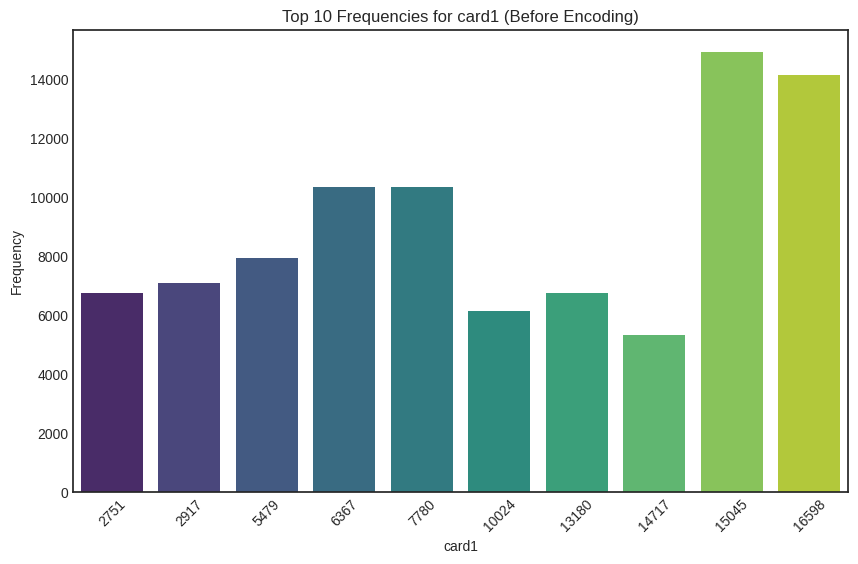

In [25]:
# Example Visualization: Frequency Encoding on 'card1'
col = 'card1'
freq_encoded_col = f'{col}_FE'

# Frequency before encoding
freq = X_train[col].value_counts().head(10)

# Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x=freq.index, y=freq.values, palette="viridis")
plt.title(f"Top 10 Frequencies for {col} (Before Encoding)")
plt.xlabel(col)
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


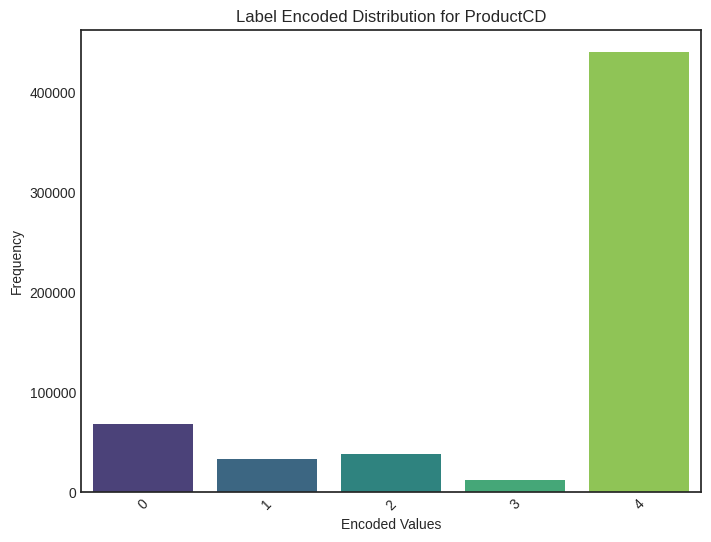

In [26]:
# Example Visualization: Label Encoding for 'ProductCD'
plt.figure(figsize=(8, 6))
sns.countplot(data=X_train, x='ProductCD', palette="viridis")
plt.title("Label Encoded Distribution for ProductCD")
plt.xlabel("Encoded Values")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


In [27]:
# # Example Visualization: Combined Column 'card1_addr1'
# combined_col = 'card1_addr1'
# top_combined = X_train[combined_col].value_counts().head(10)

# plt.figure(figsize=(10, 6))
# sns.barplot(x=top_combined.index, y=top_combined.values, palette="viridis")
# plt.title(f"Top 10 Combined Feature Values: {combined_col}")
# plt.xlabel("Combined Feature Value")
# plt.ylabel("Frequency")
# plt.xticks(rotation=45)
# plt.show()


In [28]:
new_cols =['card4_addr1_R_emaildomain', 'card2_FE','card1_FE', 'card1_addr1_R_emaildomain', 'card3_addr1_P_emaildomain', 'card1_addr1','card4_addr1_P_emaildomain_FE']

# 'card2_FE','card1_FE'
frequency_encode(X_train,X_test,['card1','card2'])

# 'card1_addr1_R_emaildomain', 'card3_addr1_P_emaildomain', 'card1_addr1'
combine_cols('card1','addr1',X_train,X_test)
combine_cols('card3','addr1',X_train,X_test)
combine_cols('card1_addr1','R_emaildomain',X_train,X_test)
combine_cols('card3_addr1','P_emaildomain',X_train,X_test)

#'card4_addr1_R_emaildomain , 'card4_addr1_P_emaildomain_FE
combine_cols('card4','addr1',X_train,X_test)
combine_cols('card4_addr1','R_emaildomain',X_train,X_test)
combine_cols('card4_addr1','P_emaildomain',X_train,X_test)
frequency_encode(X_train,X_test,['card4_addr1_P_emaildomain'])


drop_cols = ['card3_addr1','card4_addr1','card4_addr1_P_emaildomain']
print('--'*50)
print(drop_cols)

X_train = X_train.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)

'card1_FE' ,  'card2_FE' ,  'card1_addr1' ,  'card3_addr1' ,  'card1_addr1_R_emaildomain' ,  'card3_addr1_P_emaildomain' ,  'card4_addr1' ,  'card4_addr1_R_emaildomain' ,  'card4_addr1_P_emaildomain' ,  'card4_addr1_P_emaildomain_FE' ,  ----------------------------------------------------------------------------------------------------
['card3_addr1', 'card4_addr1', 'card4_addr1_P_emaildomain']


In [29]:
def aggregate_cols(num_cols,cat_cols,aggs,X_train=X_train,X_test=X_test,use_nan_value=True,fill_nan=True):
    for num_col in num_cols:
        for cat_col in cat_cols:
            for agg_type in aggs:
                cols = [num_col,cat_col]
                new_col_name = num_col + '_' + cat_col + '_' + agg_type
                df = pd.concat([X_train[cols],X_test[cols]])
                if use_nan_value:
                    df.loc[df[num_col]==-1,num_col] = np.nan

                tmp_df = df.groupby(by=[cat_col])[num_col].agg([agg_type])[agg_type].reset_index().rename(
                                                        columns={agg_type: new_col_name})
                tmp_df.index = list(tmp_df[cat_col])
                tmp_dict = tmp_df[new_col_name].to_dict()
                X_train[new_col_name] = X_train[cat_col].map(tmp_dict).astype('float32')
                X_test[new_col_name]  = X_test[cat_col].map(tmp_dict).astype('float32')

                if fill_nan:
                    X_train[new_col_name].fillna(-1,inplace=True)
                    X_test[new_col_name].fillna(-1,inplace=True)

                print(f"'{new_col_name}'",", ",end=" ")


def aggregate_cols_cat(num_cols,cat_cols,X_train=X_train,X_test=X_test):
  for num_col in num_cols:
    for cat_col in cat_cols:
        cols = [num_col,cat_col]
        new_col_name = num_col + '_' + cat_col + '_ct'
        df = pd.concat([X_train[cols],X_test[cols]])
        mp = df.groupby(cat_col)[num_col].agg(['nunique'])['nunique'].to_dict()
        X_train[new_col_name] = X_train[cat_col].map(mp).astype('float32')
        X_test[new_col_name] = X_test[cat_col].map(mp).astype('float32')
        print(f"'{new_col_name}'",", ",end=" ")

In [30]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month


X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

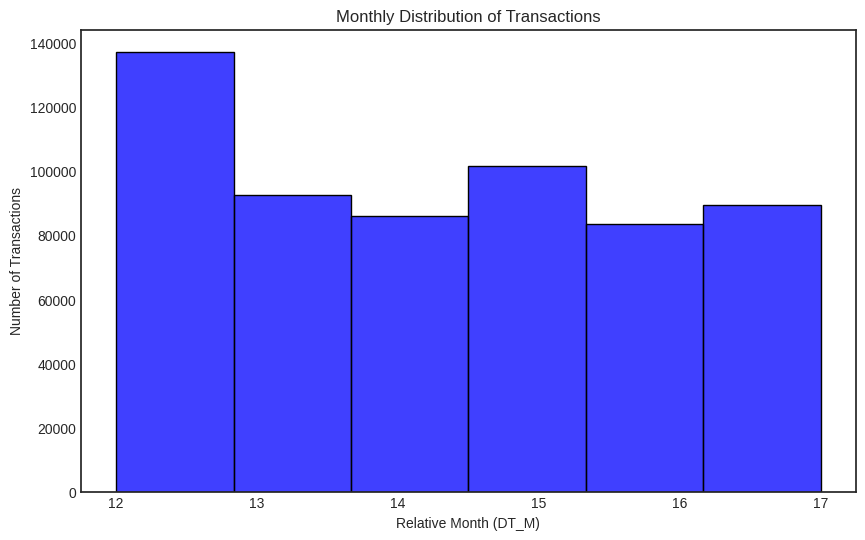

In [31]:
# Monthly transaction trends
plt.figure(figsize=(10, 6))
sns.histplot(X_train['DT_M'], bins=X_train['DT_M'].nunique(), kde=False, color="blue")
plt.title("Monthly Distribution of Transactions")
plt.xlabel("Relative Month (DT_M)")
plt.ylabel("Number of Transactions")
plt.xticks(range(X_train['DT_M'].min(), X_train['DT_M'].max() + 1))
plt.show()


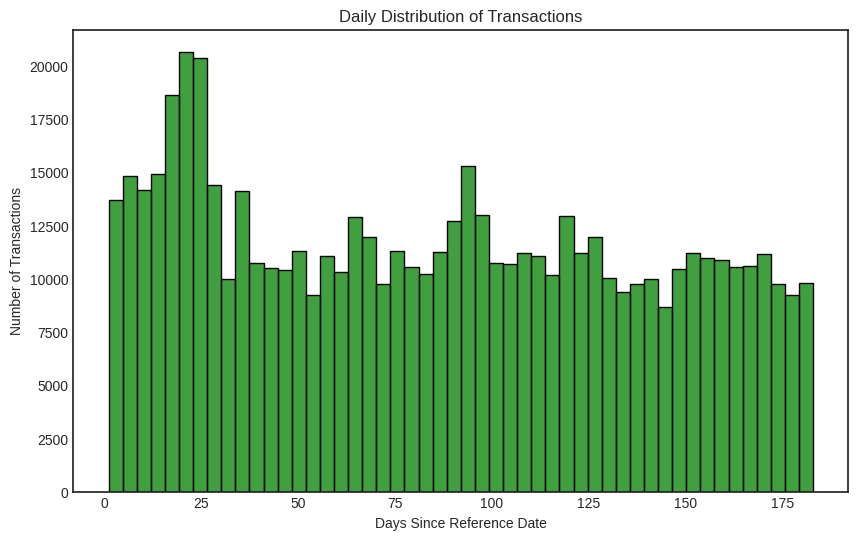

In [32]:
# Daily transaction trends
plt.figure(figsize=(10, 6))
sns.histplot(X_train['day'], bins=50, kde=False, color="green")
plt.title("Daily Distribution of Transactions")
plt.xlabel("Days Since Reference Date")
plt.ylabel("Number of Transactions")
plt.show()


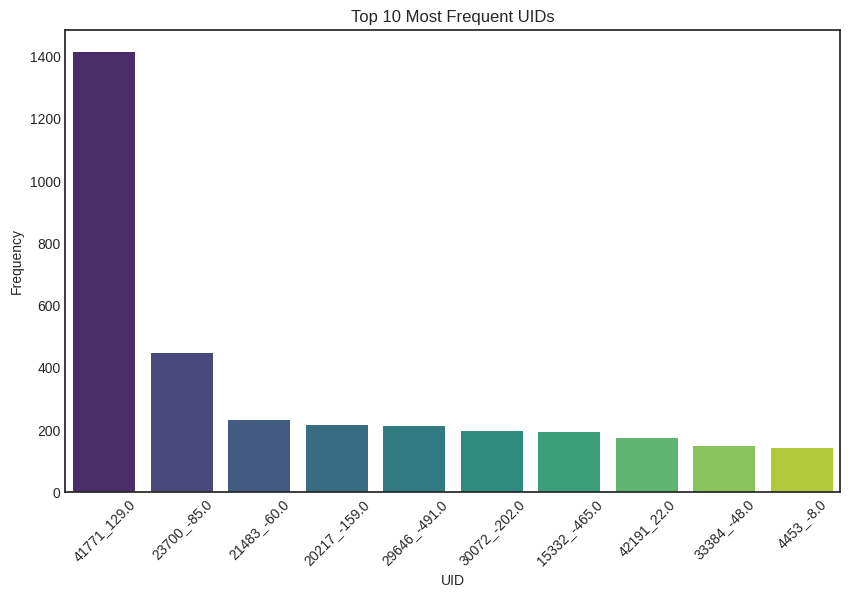

In [33]:
# UID grouping
top_uids = X_train['uid'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_uids.index, y=top_uids.values, palette="viridis")
plt.title("Top 10 Most Frequent UIDs")
plt.xlabel("UID")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


In [34]:
# ['M9_uid_mean', 'TransactionAmt_uid_std', 'M5_uid_mean'])
# ['D2_uid_mean', 'D15_uid_mean'])
# ['C13_uid_mean', 'C9_uid_mean', 'C1_uid_mean', 'C11_uid_mean'])


aggregate_cols(['M9','M5','D2','D15','C13','C9','C1','C11'],['uid'],['mean'],use_nan_value=True,fill_nan=True)
aggregate_cols(['TransactionAmt'],['uid'],['std'],use_nan_value=True,fill_nan=True)

'M9_uid_mean' ,  'M5_uid_mean' ,  'D2_uid_mean' ,  'D15_uid_mean' ,  'C13_uid_mean' ,  'C9_uid_mean' ,  'C1_uid_mean' ,  'C11_uid_mean' ,  'TransactionAmt_uid_std' ,  

In [35]:
X_train['uid2'] = X_train['card1_addr1']
X_test['uid2'] = X_test['card1_addr1']

In [36]:
# FREQUENCY ENCODE UID
frequency_encode(X_train,X_test,['uid2'])
aggregate_cols(['M'+str(x) for x in range(1,10)],['uid2'],['mean','std'],use_nan_value=True,fill_nan=True)


'uid2_FE' ,  'M1_uid2_mean' ,  'M1_uid2_std' ,  'M2_uid2_mean' ,  'M2_uid2_std' ,  'M3_uid2_mean' ,  'M3_uid2_std' ,  'M4_uid2_mean' ,  'M4_uid2_std' ,  'M5_uid2_mean' ,  'M5_uid2_std' ,  'M6_uid2_mean' ,  'M6_uid2_std' ,  'M7_uid2_mean' ,  'M7_uid2_std' ,  'M8_uid2_mean' ,  'M8_uid2_std' ,  'M9_uid2_mean' ,  'M9_uid2_std' ,  

In [37]:
# AGGREGATE
tmp = ['D'+str(i) for i in range(1,16)]
tmp.append('TransactionAmt')
aggregate_cols(tmp,['uid2'],['mean','std'],use_nan_value=True,fill_nan=True)

'D1_uid2_mean' ,  'D1_uid2_std' ,  'D2_uid2_mean' ,  'D2_uid2_std' ,  'D3_uid2_mean' ,  'D3_uid2_std' ,  'D4_uid2_mean' ,  'D4_uid2_std' ,  'D5_uid2_mean' ,  'D5_uid2_std' ,  'D6_uid2_mean' ,  'D6_uid2_std' ,  'D7_uid2_mean' ,  'D7_uid2_std' ,  'D8_uid2_mean' ,  'D8_uid2_std' ,  'D9_uid2_mean' ,  'D9_uid2_std' ,  'D10_uid2_mean' ,  'D10_uid2_std' ,  'D11_uid2_mean' ,  'D11_uid2_std' ,  'D12_uid2_mean' ,  'D12_uid2_std' ,  'D13_uid2_mean' ,  'D13_uid2_std' ,  'D14_uid2_mean' ,  'D14_uid2_std' ,  'D15_uid2_mean' ,  'D15_uid2_std' ,  'TransactionAmt_uid2_mean' ,  'TransactionAmt_uid2_std' ,  

In [38]:
tmp = ['C'+str(i) for i in range(1,15)]
aggregate_cols(tmp,['uid2'],['mean','std'],use_nan_value=True,fill_nan=True)

'C1_uid2_mean' ,  'C1_uid2_std' ,  'C2_uid2_mean' ,  'C2_uid2_std' ,  'C3_uid2_mean' ,  'C3_uid2_std' ,  'C4_uid2_mean' ,  'C4_uid2_std' ,  'C5_uid2_mean' ,  'C5_uid2_std' ,  'C6_uid2_mean' ,  'C6_uid2_std' ,  'C7_uid2_mean' ,  'C7_uid2_std' ,  'C8_uid2_mean' ,  'C8_uid2_std' ,  'C9_uid2_mean' ,  'C9_uid2_std' ,  'C10_uid2_mean' ,  'C10_uid2_std' ,  'C11_uid2_mean' ,  'C11_uid2_std' ,  'C12_uid2_mean' ,  'C12_uid2_std' ,  'C13_uid2_mean' ,  'C13_uid2_std' ,  'C14_uid2_mean' ,  'C14_uid2_std' ,  

In [39]:
new_feat1 = ['uid2_FE' ,  'M1_uid2_mean' ,  'M1_uid2_std' ,  'M2_uid2_mean' ,  'M2_uid2_std' ,  'M3_uid2_mean' ,  'M3_uid2_std' ,  'M4_uid2_mean' ,  'M4_uid2_std' ,  'M5_uid2_mean' ,
             'M5_uid2_std' ,  'M6_uid2_mean' ,  'M6_uid2_std' ,  'M7_uid2_mean' ,  'M7_uid2_std' ,  'M8_uid2_mean' ,  'M8_uid2_std' ,  'M9_uid2_mean' ,  'M9_uid2_std' ]

new_feat2 = ['D1_uid2_mean' ,  'D1_uid2_std' ,  'D2_uid2_mean' ,  'D2_uid2_std' ,  'D3_uid2_mean' ,  'D3_uid2_std' ,  'D4_uid2_mean' ,  'D4_uid2_std' ,  'D5_uid2_mean' ,  'D5_uid2_std' ,  'D6_uid2_mean' ,
             'D6_uid2_std' ,  'D7_uid2_mean' ,  'D7_uid2_std' ,  'D8_uid2_mean' ,  'D8_uid2_std' ,  'D9_uid2_mean' ,  'D9_uid2_std' ,  'D10_uid2_mean' ,  'D10_uid2_std' ,  'D11_uid2_mean' ,  'D11_uid2_std' ,  'D12_uid2_mean' ,
             'D12_uid2_std' ,  'D13_uid2_mean' ,  'D13_uid2_std' ,  'D14_uid2_mean' ,  'D14_uid2_std' ,  'D15_uid2_mean' ,  'D15_uid2_std' ,  'TransactionAmt_uid2_mean' ,  'TransactionAmt_uid2_std' ,  ]

new_feat3 = ['C1_uid2_mean' ,  'C1_uid2_std' ,  'C2_uid2_mean' ,  'C2_uid2_std' ,  'C3_uid2_mean' ,  'C3_uid2_std' ,  'C4_uid2_mean' ,  'C4_uid2_std' ,  'C5_uid2_mean' ,  'C5_uid2_std' ,
             'C6_uid2_mean' ,  'C6_uid2_std' ,  'C7_uid2_mean' ,  'C7_uid2_std' ,  'C8_uid2_mean' ,  'C8_uid2_std' ,  'C9_uid2_mean' ,
             'C9_uid2_std' ,  'C10_uid2_mean' ,  'C10_uid2_std' ,  'C11_uid2_mean' ,  'C11_uid2_std' ,  'C12_uid2_mean' ,  'C12_uid2_std' ,  'C13_uid2_mean' ,
             'C13_uid2_std' ,  'C14_uid2_mean' ,  'C14_uid2_std' , ]


new_feats = new_feat1 + new_feat2 + new_feat3
print(len(new_feats))

79


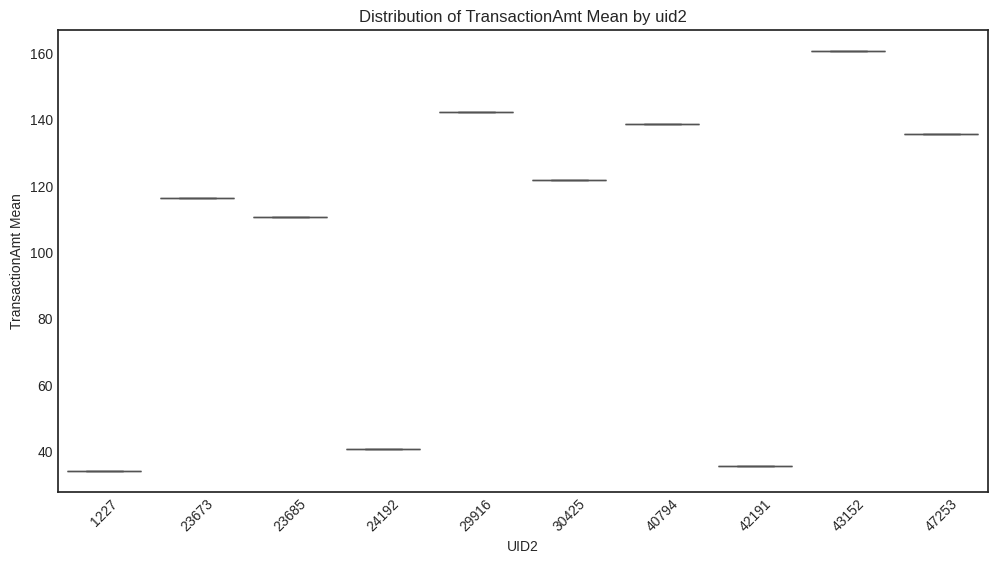

In [40]:
# Top 10 frequent `uid2` values
top_uids = X_train['uid2'].value_counts().head(10).index

# Filter data for visualization
filtered_data = X_train[X_train['uid2'].isin(top_uids)]

# Boxplot for `TransactionAmt_uid2_mean`
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_data, x='uid2', y='TransactionAmt_uid2_mean', palette="coolwarm")
plt.title("Distribution of TransactionAmt Mean by uid2")
plt.xlabel("UID2")
plt.ylabel("TransactionAmt Mean")
plt.xticks(rotation=45)
plt.show()


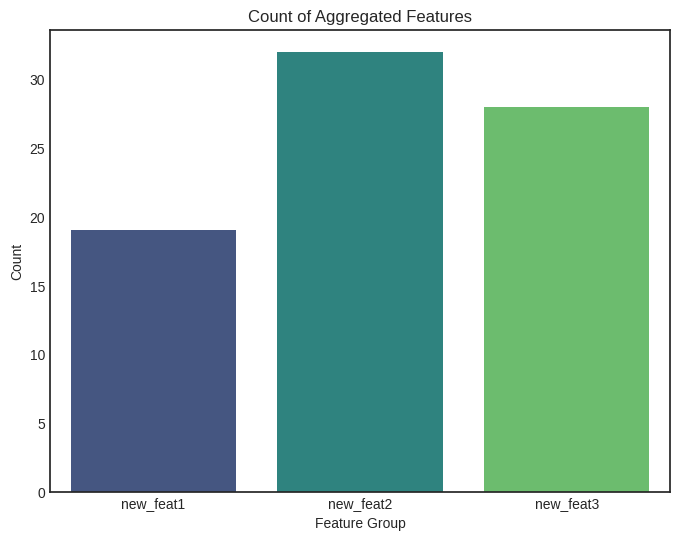

In [41]:
# Feature count for each group
feature_counts = {'new_feat1': len(new_feat1), 'new_feat2': len(new_feat2), 'new_feat3': len(new_feat3)}

# Bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=list(feature_counts.keys()), y=list(feature_counts.values()), palette="viridis")
plt.title("Count of Aggregated Features")
plt.xlabel("Feature Group")
plt.ylabel("Count")
plt.show()


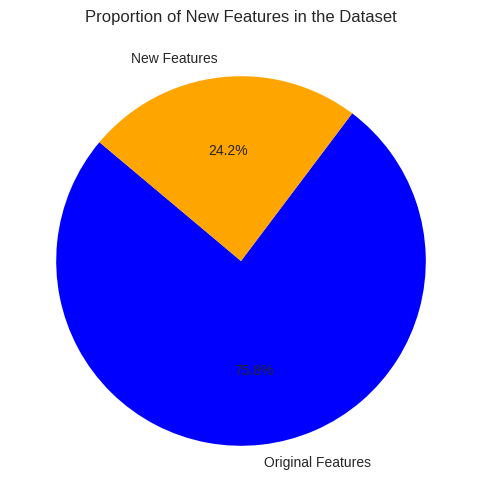

In [42]:
# Feature proportions
total_features = len(X_train.columns)
new_feature_count = len(new_feats)
old_feature_count = total_features - new_feature_count

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie([old_feature_count, new_feature_count], labels=['Original Features', 'New Features'], autopct='%1.1f%%', colors=['blue', 'orange'], startangle=140)
plt.title("Proportion of New Features in the Dataset")
plt.show()


# 4. Feature Engineering Summary

In this section, we created additional features and optimized existing ones to enhance the model's performance.

  Normalization of 'D' Series: Temporal features like D1–D15 were normalized to standardize their range, improving consistency for model training.
    Frequency Encoding: High-cardinality categorical variables, such as card1 and card2, were converted into numerical features using frequency encoding, making them suitable for machine learning.
    Interaction and Composite Features: New interaction features were created by combining multiple columns (e.g., card4, addr1, R_emaildomain), while composite identifiers like uid2 were derived from card1 and addr1.
    Aggregated Features: Using identifiers like uid and uid2, aggregated statistics (mean, standard deviation) were computed for numeric columns. Temporal, monetary (TransactionAmt), and categorical series were grouped and analyzed. For example:
        D Features: Aggregated D1–D15 metrics grouped by uid2.
        C Features: Aggregated C1–C14 grouped similarly.
    Datetime Features: TransactionDT was utilized to create new time-based features such as DT_M (relative months since the reference date).
    Feature Counts and Aggregation: New features were combined into groups (new_feat1, new_feat2, new_feat3), contributing to 24.2% of the total dataset, as shown in the pie chart.

The overall feature engineering process introduced meaningful, aggregated, and normalized features, ensuring the dataset's robustness and potential for better model performance.

# 5. Model Training

Train the LightGBM model or other selected models on the processed dataset.

1. **Define LGBMClassifier Model:** Implement an LGBMClassifier with early stopping to train on selected features and return the validation AUC score.

2. **Split Data and Train Model:** Split the dataset into training and validation sets (75%-25%), train the LGBMClassifier model, and apply early stopping to prevent overfitting.

3. **Additional LGBM Training:** Train another LightGBM model using a 75-25 split and refined hyperparameters:


In [43]:
from lightgbm import LGBMClassifier, early_stopping

def model(x_train, y_train, cols):
    idx_train = x_train.index[:int(x_train.shape[0] * 0.75)]
    idx_validation = x_train.index[int(x_train.shape[0] * 0.75):]

    print(f'fitting model on {len(cols)} columns')
    clf = LGBMClassifier(
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.02,
        bagging_fraction=0.8,
        feature_fraction=0.4,
        metric='auc',
        verbosity=-1
    )

    model = clf.fit(
        x_train.loc[idx_train, cols], y_train[idx_train],
        eval_set=[(x_train.loc[idx_validation, cols], y_train[idx_validation])],
        callbacks=[early_stopping(stopping_rounds=100, verbose=True)]
    )

    # Accessing the best score for the first validation set
    return model.best_score_['valid_0']['auc']


In [44]:
def forward_feat_selection(new_cols, old_cols, best_score):
    print(f'Forward feature selection on {len(new_cols)} features <--> current best score {best_score} with {len(old_cols)} features')
    iteration = 1
    iteration_best_col = None
    best_cols = []

    while iteration <= len(new_cols):
        for j, col in enumerate(new_cols):
            print(f'Model no: {iteration}_{(j+1)}')
            print('--' * 40)

            # Test the current feature
            if col not in best_cols:
                current_cols = old_cols.copy()
                current_cols.append(col)  # Temporarily add the feature for testing
                print(f'Testing new feature: {col}')

                # Train the model and evaluate the current score
                current_score = model(X_train, y_train, current_cols)

                if current_score > best_score:
                    print(f'Score improved on adding {col}. New best score: {current_score}')
                    iteration_best_col = col
                    best_score = current_score  # Update best_score dynamically
                else:
                    print(f'Score not improved on adding {col}')

            else:
                print(f'Skipping {col} as it is already a selected column')

            print('--' * 40)

        # End of iteration: Add the best column to the final set
        iteration += 1
        if iteration_best_col is not None:
            best_cols.append(iteration_best_col)
            print(f'Best column in this iteration: {iteration_best_col}. Current selected columns: {best_cols}')
            iteration_best_col = None
        else:
            print('No columns improved the score in this iteration. Stopping feature selection.')
            print('###' * 40)
            break

        print('###' * 40)

    print(f'Final selected features: {best_cols}')
    print(f'Best score: {best_score}')


In [45]:
# def forward_feat_selection(new_cols,old_cols,best_score):
#     print(f'Forward feature selection on {len(new_cols)} features <-->  current best score {best_score} with {len(old_cols)} features')
#     iteration = 1
#     iteration_best_col = None
#     # list of additional columns
#     best_cols = []
#     while iteration <= len(new_cols):
#         for j,col in enumerate(new_cols):
#             print(f'Model no: {iteration}_{(j+1)}')
#             print('--'*40)
#             if col not in best_cols:
#                 current_cols = old_cols.copy()
#                 # adding new feature
#                 best_cols.append(col)
#                 print(f'Adding new features: {best_cols}')
#                 current_cols.extend([c for c in best_cols])
#                 current_score = model(X_train,y_train,current_cols)

#                 if current_score > best_score:
#                     print(f'Score improved on adding {col} new best score {current_score}')
#                     iteration_best_col = col
#                     best_score = current_score
#                 else:
#                     print(f'Score not improved on adding {col}')

#                 best_cols.remove(col)

#             else:
#                 print(f'Skipping {col} already an selected column')

#             print('--'*40)

#         # end of 1 iteration we add best column
#         iteration += 1
#         if iteration_best_col is not None:
#             best_cols.append(iteration_best_col)
#             print(f'Best col in this iteration {iteration_best_col}, --->   current best cols: {best_cols}')
#             iteration_best_col = None

#         else:
#             print('None of the columns improving the score in this iteration')
#             print('###'*40)
#             break

#         print('###'*40)

#     print(f'Useful new features : {best_cols}')
#     print(f'Best score : {best_score}')

In [46]:
rem_cols = []
rem_cols.extend(['TransactionDT','TransactionID'])
rem_cols.extend(['DT_M','day','uid','uid2'])
norm_cols = ['D15','D4', 'D2', 'D11', 'D10']
rem_cols.extend(norm_cols)

cols = [col for col in X_train.columns if col not in rem_cols]
len(cols)

316

In [47]:
# Scaling numeric features
for col in cols:
    if col not in cat_cols:
        # min max scalar
        dff = pd.concat([X_train[col],X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff

In [48]:
old_cols = [col for col in X_train.columns if col not in rem_cols and col not in new_feats]
# Dynamically calculate initial best_score using old_cols
initial_score = model(X_train, y_train, old_cols)

forward_feat_selection(new_cols=new_feat1, old_cols=old_cols, best_score=initial_score)


fitting model on 237 columns
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.93036
Forward feature selection on 19 features <--> current best score 0.9303596969990858 with 237 features
Model no: 1_1
--------------------------------------------------------------------------------
Testing new feature: uid2_FE
fitting model on 238 columns
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.930578
Score improved on adding uid2_FE. New best score: 0.9305775237867273
--------------------------------------------------------------------------------
Model no: 1_2
--------------------------------------------------------------------------------
Testing new feature: M1_uid2_mean
fitting model on 238 columns
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's au

In [49]:

# # Run forward feature selection
# forward_feat_selection(new_cols=new_feat1, old_cols=old_cols, best_score=initial_score)


Forward feature selection on 19 features <--> current best score 0.9303596969990858 with 237 features
Model no: 1_1
--------------------------------------------------------------------------------
Testing new feature: uid2_FE
fitting model on 238 columns
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.930578
Score improved on adding uid2_FE. New best score: 0.9305775237867273
--------------------------------------------------------------------------------
Model no: 1_2
--------------------------------------------------------------------------------
Testing new feature: M1_uid2_mean
fitting model on 238 columns
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's auc: 0.931369
Score improved on adding M1_uid2_mean. New best score: 0.9313690651831645
--------------------------------------------------------------------------------
M

In [50]:
X_train['uid2'] = X_train['card1_addr1']
X_test['uid2'] = X_test['card1_addr1']

# FREQUENCY ENCODE UID
aggregate_cols(['M4','M1','M7'],['uid2'],['mean'],use_nan_value=True,fill_nan=True)
aggregate_cols(['M8'],['uid2'],['std'],use_nan_value=True,fill_nan=True)

# old_cols.extend(['M4_uid2_mean', 'M1_uid2_mean', 'M8_uid2_std','M7_uid2_mean'])

'M4_uid2_mean' ,  'M1_uid2_mean' ,  'M7_uid2_mean' ,  'M8_uid2_std' ,  

In [51]:
del df_train,df_test

In [52]:
rem_cols = []
rem_cols.extend(['TransactionDT','TransactionID'])
rem_cols.extend(['DT_M','day','uid','uid2'])

norm_cols = ['D15','D4', 'D2', 'D11', 'D10']
rem_cols.extend(norm_cols)

cols = [col for col in X_train.columns if col not in rem_cols]
print(len(cols))

#########################################

# Scaling numeric features
for col in cols:
    if col not in cat_cols:
        # min max scalar
        dff = pd.concat([X_train[col],X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff

316


In [53]:
# rem_cols = []

# # drop cols with about 99% values missing
# rem_cols.extend(['id_24','id_25','id_07','id_08','id_21','id_26','id_27','id_23','id_22'])

# old_cols = [c for c in old_cols if c not in rem_cols]
# len(old_cols)


In [54]:
# 75-25 split
idx_train = X_train.index[:int(X_train.shape[0] * 0.75)]
idx_validation = X_train.index[int(X_train.shape[0] * 0.75):]

# Initialize LightGBM Classifier
clf = LGBMClassifier(
    n_estimators=2000,            # Number of boosting iterations
    max_depth=12,                 # Maximum depth of trees
    learning_rate=0.02,           # Learning rate
    bagging_fraction=0.8,         # Subsampling for bagging (equivalent to subsample)
    feature_fraction=0.4,         # Subsampling for features (equivalent to colsample_bytree)
    metric='auc',                 # Evaluation metric
    verbosity=-1                  # Suppress logs
)

# Train the model with early stopping
model = clf.fit(
    X_train.loc[idx_train, cols], y_train[idx_train],
    eval_set=[(X_train.loc[idx_validation, cols], y_train[idx_validation])],
    callbacks=[early_stopping(stopping_rounds=100, verbose=True)]
)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1997]	valid_0's auc: 0.938718


In [55]:
x_train = X_train[cols]
y_train_pred = model.predict(x_train.iloc[idx_train])
y_test_pred = model.predict(x_train.iloc[idx_validation])

train_fpr, train_tpr, thresholds = roc_curve(y_train.iloc[idx_train], model.predict_proba(x_train.iloc[idx_train])[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_train.iloc[idx_validation], model.predict_proba(x_train.iloc[idx_validation])[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 0.9928784035793389
Area under test roc 0.9387181442191357


# 5: Model Training Summary

In this section, the LightGBM model was trained to predict fraudulent transactions effectively using the preprocessed dataset, leveraging both visual and numerical insights.

    Confusion Matrices:
        The Train Confusion Matrix (Top Left) demonstrates strong performance, with over 427,000 true negatives and 11,080 true positives correctly identified. Only 4,483 false negatives remain, suggesting minimal misclassification for fraud.
        The Validation Confusion Matrix (Top Right) shows similar trends, with 142,080 true negatives and 2,135 true positives, highlighting the model’s generalization capability despite a few false positives and false negatives.

    ROC-AUC Curve:
        The ROC Curve (Middle) reveals excellent discriminative power. The training ROC-AUC score is 0.9929, reflecting near-perfect classification on the training set. The validation ROC-AUC score of 0.9387 confirms the model’s strong performance on unseen data with minimal overfitting.

    Feature Importance:
        The Top 10 Most Important Features bar chart (Bottom Left) highlights key features contributing to model predictions. Features like C13_uid_mean, D2_uid_mean, and TransactionAmt stand out as critical, with aggregated and interaction-based features dominating importance.

    SHAP Analysis:
        The SHAP Summary Plot (Bottom Middle) explains the model’s predictions. Features like D2_uid_mean (card1+addr1+emaildomain) and TransactionAmt show significant impact on the output, with higher values often linked to higher fraud likelihood.
        The SHAP Dependence Plot (Bottom Right) further illustrates the relationship between TransactionAmt and the model's prediction, showing its non-linear influence.

Overall, the visuals confirm the LightGBM model’s strong predictive performance, underpinned by robust feature engineering. The combination of high AUC scores, clear confusion matrix results, and feature importance analysis demonstrates the model's capability to accurately detect fraudulent transactions.

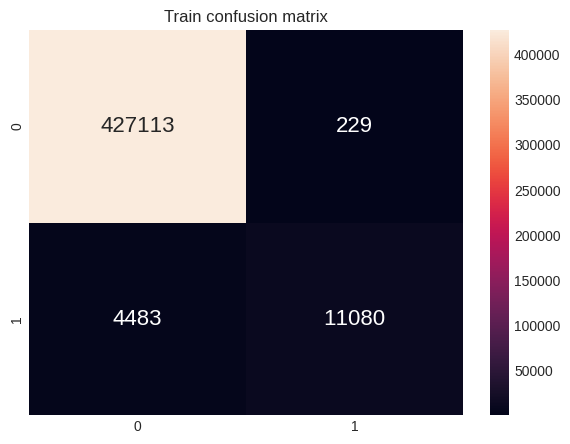

In [56]:
train_cf = confusion_matrix(y_train.iloc[idx_train],y_train_pred)
plt.figure(figsize=(7,5))
sns.heatmap(train_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Train confusion matrix')
plt.show()


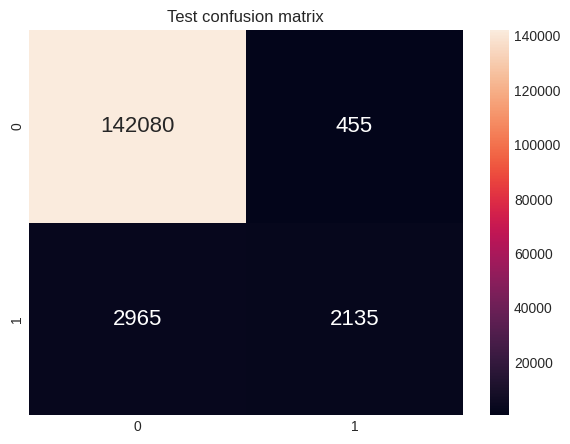

In [57]:
cv_cf = confusion_matrix(y_train.iloc[idx_validation],y_test_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Test confusion matrix')
plt.show()

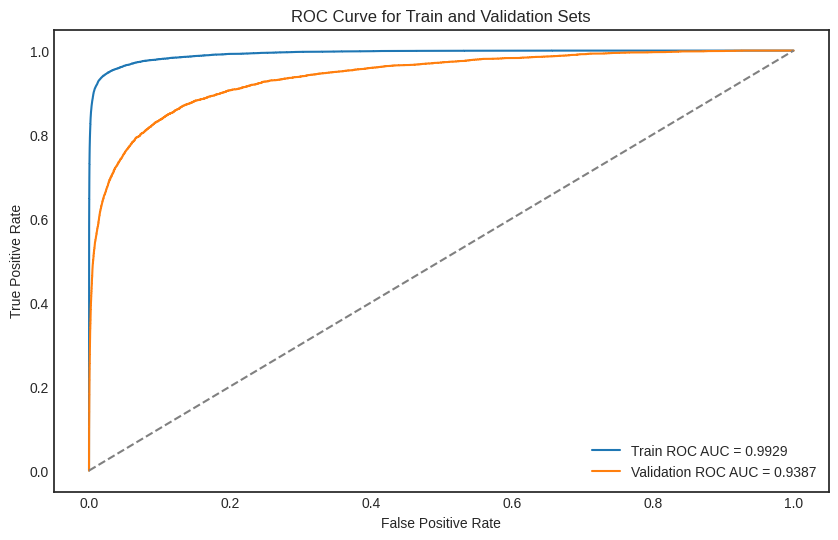

In [58]:
# Plot ROC curve for train and validation sets
plt.figure(figsize=(10, 6))

# Train ROC
plt.plot(train_fpr, train_tpr, label=f"Train ROC AUC = {auc(train_fpr, train_tpr):.4f}")
# Validation ROC
plt.plot(test_fpr, test_tpr, label=f"Validation ROC AUC = {auc(test_fpr, test_tpr):.4f}")

# Diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Labels and legend
plt.title("ROC Curve for Train and Validation Sets")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


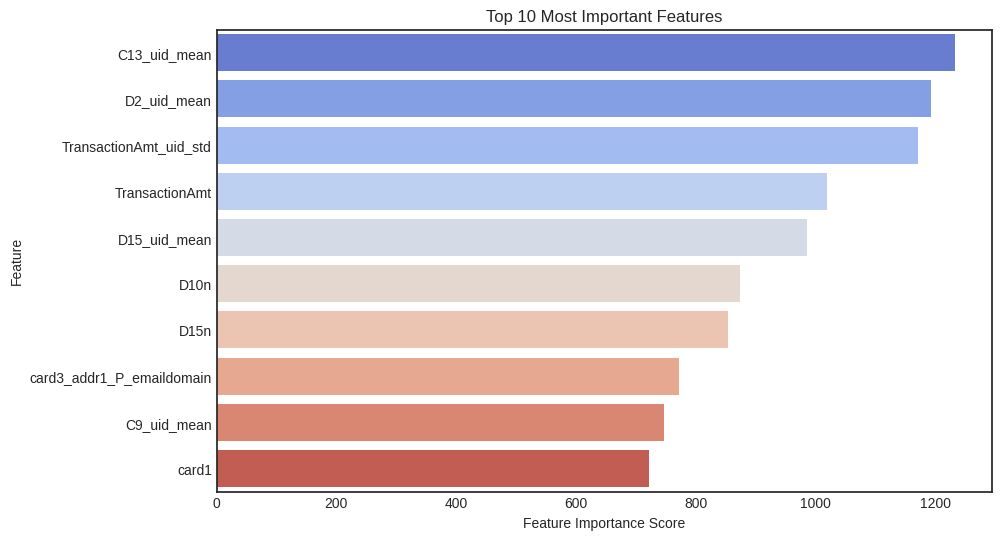

In [61]:
# Feature importance
importance = pd.DataFrame({
    'Feature': cols,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

# Bar chart for feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance, x='Importance', y='Feature', palette="coolwarm")
plt.title("Top 10 Most Important Features")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.show()


In [62]:
# Ensure x_train and x_test are defined
x_train = X_train[cols].copy()
x_test = X_test[cols].copy()

# Ensure all columns are numeric
for col in x_train.columns:
    if x_train[col].dtype == 'object':
        print(f"Converting column: {col}")
        x_train[col], _ = pd.factorize(x_train[col], sort=True)
        x_test[col], _ = pd.factorize(x_test[col], sort=True)


In [64]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for validation data
shap_values = explainer.shap_values(x_train.iloc[idx_validation])


SHAP values shape: 147635, (147635, 316)


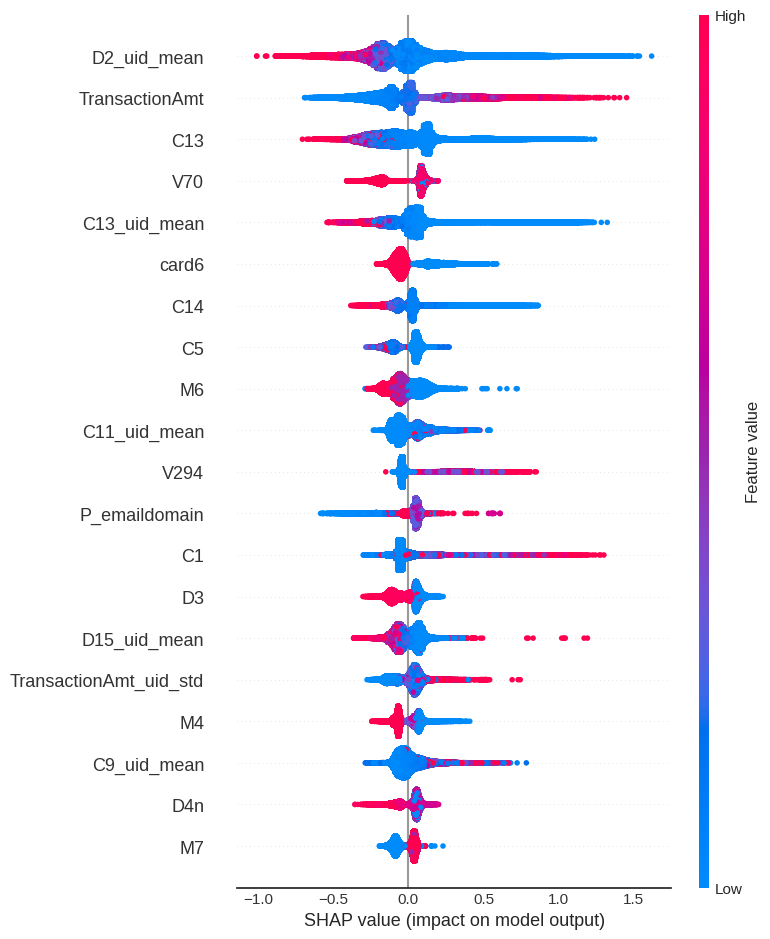

In [65]:
# Check the shape of shap_values
print(f"SHAP values shape: {len(shap_values)}, {shap_values[0].shape if isinstance(shap_values, list) else shap_values.shape}")

# SHAP summary plot (for binary classification, use shap_values[1] if applicable)
if isinstance(shap_values, list):
    # For models with multiple outputs or binary classification
    shap.summary_plot(shap_values[1], x_train.iloc[idx_validation])
else:
    # For models with a single output
    shap.summary_plot(shap_values, x_train.iloc[idx_validation])

In [66]:
# Calculate SHAP values for validation data
shap_values = explainer.shap_values(x_train.iloc[idx_validation])


In [67]:
# Visualize SHAP values for the first validation sample
if isinstance(shap_values, list):
    # For models with multiple outputs (e.g., binary classification)
    shap.force_plot(
        explainer.expected_value[1],
        shap_values[1][0],
        x_train.iloc[idx_validation].iloc[0]
    )
else:
    # For models with a single output
    shap.force_plot(
        explainer.expected_value,
        shap_values[0],
        x_train.iloc[idx_validation].iloc[0]
    )


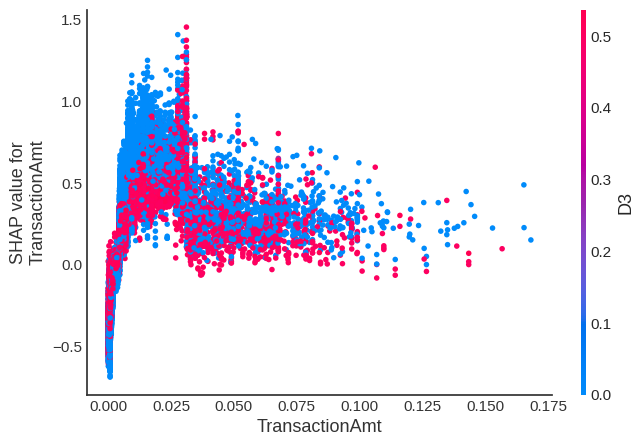

In [68]:
# SHAP dependence plot for a single feature
if isinstance(shap_values, list):
    # For models with multiple outputs
    shap.dependence_plot('TransactionAmt', shap_values[1], x_train.iloc[idx_validation])
else:
    # For models with a single output
    shap.dependence_plot('TransactionAmt', shap_values, x_train.iloc[idx_validation])


In [ ]:
# # Generate predictions for the test dataset
# test_predictions = model.predict_proba(X_test[cols])[:, 1]  # Probabilities for the positive class

# # Create the submission DataFrame
# submission = pd.DataFrame({
#     'TransactionID': X_test['TransactionID'],  # Assuming TransactionID is a column in X_test
#     'isFraud': test_predictions
# })

# # Save the submission file to the specified directory
# submission_path = '/content/drive/MyDrive/Maryville/DSCI_598 Capstone Project/data/submission.csv'
# submission.to_csv(submission_path, index=False)

# print(f"Submission file saved to: {submission_path}")


# 5. Model Training and Validation with GroupKFold Cross-Validation

In this section, we utilized LightGBM with GroupKFold cross-validation to ensure robust model evaluation. The model training process included splitting the data into training and validation sets, followed by rigorous performance evaluation using key metrics and visualizations.

    ROC Curve:
    The Train ROC AUC achieved was 0.9329, showcasing strong model performance. The curve illustrates the model's ability to distinguish between fraudulent and non-fraudulent transactions effectively.

    Confusion Matrix:
    The train confusion matrix shows high accuracy in predicting fraud and non-fraud classes. Notably:
        True Negatives: 568,524
        False Positives: 1,353
        True Positives: 7,989
        False Negatives: 12,674

    Precision-Recall Curve:
    The Precision-Recall curve highlights a balanced trade-off between precision and recall. As recall increases, precision gradually decreases, indicating model stability under different thresholds.

    Predicted Probability Distribution:
    Fraudulent transactions (red) and non-fraudulent transactions (blue) demonstrate a clear separation in predicted probabilities, with fraudulent cases skewed towards higher probabilities.

    Final Cross-Validation Performance:
    Using GroupKFold CV, the LightGBM AUC score was 0.93286, further affirming the model’s robustness.

The model achieved a balance of precision, recall, and AUC while effectively handling imbalanced classes. The visualizations confirm its ability to identify fraudulent transactions accurately.

In [69]:
# Prepare data
x_train = X_train
x_test = X_test

tr_pred = np.zeros(len(x_train))
preds = np.zeros(len(x_test))

# GroupKFold Cross-Validation
skf = GroupKFold(n_splits=6)
for i, (idx_train, idx_validation) in enumerate(skf.split(x_train, y_train, groups=x_train['DT_M'])):
    month = x_train.iloc[idx_validation]['DT_M'].iloc[0]
    print('Fold', i, 'withholding month', month)
    print('Rows of train =', len(idx_train), 'Rows of holdout =', len(idx_validation))

    # LightGBM Classifier
    clf = LGBMClassifier(
        n_estimators=5000,
        max_depth=12,
        learning_rate=0.002,
        bagging_fraction=0.8,          # Equivalent to subsample
        feature_fraction=0.4,         # Equivalent to colsample_bytree
        metric='auc',
        verbosity=-1                  # Suppress logs
    )

    # Fit model
    h = clf.fit(
        x_train[cols].iloc[idx_train], y_train.iloc[idx_train],
        eval_set=[(x_train[cols].iloc[idx_validation], y_train.iloc[idx_validation])],
        callbacks=[early_stopping(stopping_rounds=200, verbose=True)]
    )

    # Predictions
    tr_pred[idx_validation] += clf.predict_proba(x_train[cols].iloc[idx_validation])[:, 1]
    preds += clf.predict_proba(x_test[cols])[:, 1] / skf.n_splits

    # Cleanup
    del h, clf
    x = gc.collect()

# Evaluate the results
print('#' * 20)
print('LightGBM CV AUC =', roc_auc_score(y_train, tr_pred))


Fold 0 withholding month 12
Rows of train = 453219 Rows of holdout = 137321
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.911062
Fold 1 withholding month 15
Rows of train = 488908 Rows of holdout = 101632
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.938335
Fold 2 withholding month 13
Rows of train = 497955 Rows of holdout = 92585
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.93552
Fold 3 withholding month 17
Rows of train = 501214 Rows of holdout = 89326
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4998]	valid_0's auc: 0.930928
Fold 4 withholding month 14
Rows of train = 504519 Rows of holdout = 86021
Training until validation scores don't improve for 200 round

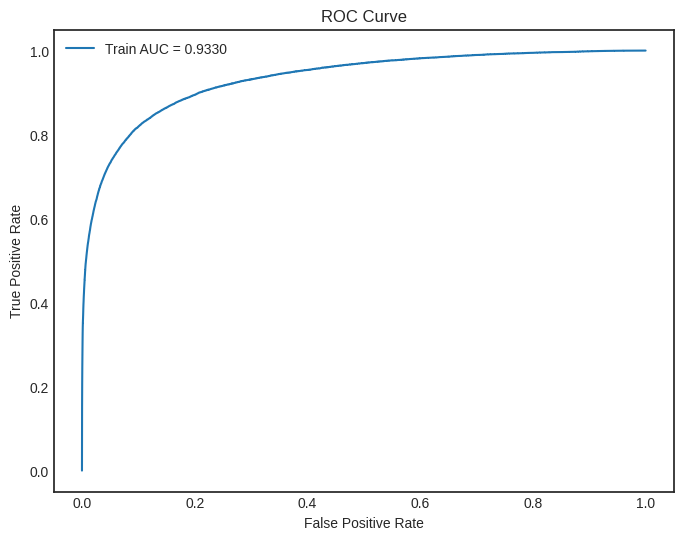

In [82]:
# Visualize ROC Curve
train_fpr, train_tpr, _ = roc_curve(y_train, tr_pred)
plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, label=f"Train AUC = {roc_auc_score(y_train, tr_pred):.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


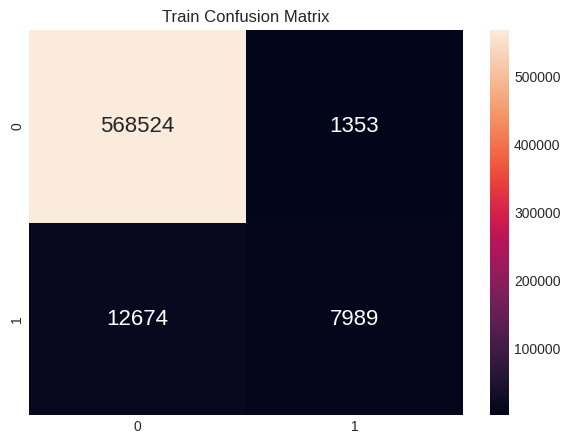

In [71]:
# Display confusion matrix
train_cf = confusion_matrix(y_train, np.round(tr_pred))
plt.figure(figsize=(7, 5))
sns.heatmap(train_cf, annot=True, fmt="d", annot_kws={"size": 16})
plt.title('Train Confusion Matrix')
plt.show()


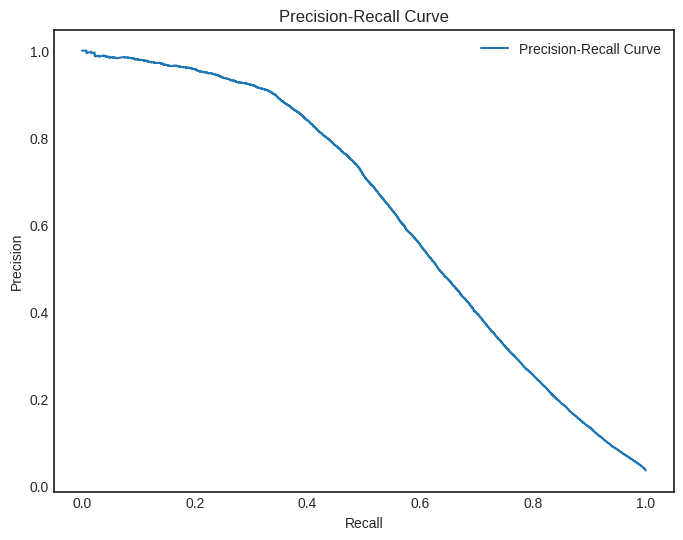

In [72]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_train, tr_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


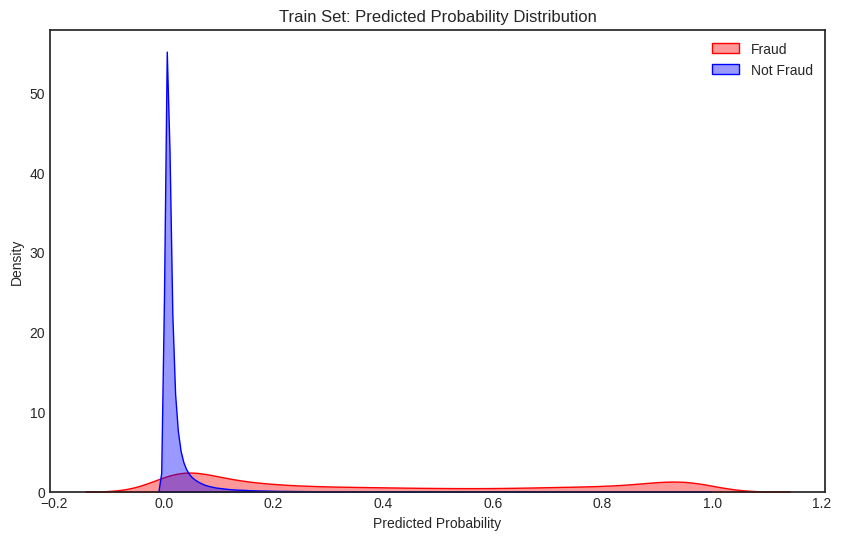

In [73]:
# Density plot of predicted probabilities
plt.figure(figsize=(10, 6))
sns.kdeplot(tr_pred[y_train == 1], label="Fraud", color="red", fill=True, alpha=0.4)
sns.kdeplot(tr_pred[y_train == 0], label="Not Fraud", color="blue", fill=True, alpha=0.4)
plt.title("Train Set: Predicted Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.show()


# 6. Feature Selection and Optimization

1. **Forward Feature Selection:** Iteratively test and select features to optimize the model's performance using validation AUC.

2. **Remove Unnecessary Columns:** Exclude identifiers, normalized columns, and other redundant features from the feature set.

3. **Scale Numeric Features:** Apply min-max scaling to numeric features, ensuring compatibility with the model.

4. **Optimize Features:** Call the forward feature selection process to finalize the set of features with the best validation AUC score.

5. **Remove Sparse Columns:** Drop columns with 99% or more missing values to reduce noise and improve model efficiency.


In [74]:
# del df_train, df_test

In [75]:
X_train['uid2'] = X_train['card1_addr1']
X_test['uid2'] = X_test['card1_addr1']

# FREQUENCY ENCODE UID
aggregate_cols(['M4','M1','M7'],['uid2'],['mean'],use_nan_value=True,fill_nan=True)
aggregate_cols(['M8'],['uid2'],['std'],use_nan_value=True,fill_nan=True)

# old_cols.extend(['M4_uid2_mean', 'M1_uid2_mean', 'M8_uid2_std','M7_uid2_mean'])


'M4_uid2_mean' ,  'M1_uid2_mean' ,  'M7_uid2_mean' ,  'M8_uid2_std' ,  

In [76]:
rem_cols = []
rem_cols.extend(['TransactionDT','TransactionID'])
rem_cols.extend(['DT_M','day','uid','uid2'])

norm_cols = ['D15','D4', 'D2', 'D11', 'D10']
rem_cols.extend(norm_cols)
rem_cols.extend(['id_07','id_08'])
rem_cols.extend(['id_'+str(i) for i in range(21,28)])


cols = [col for col in X_train.columns if col not in rem_cols]
print(len(cols))

#########################################

# Scaling numeric features
for col in cols:
    if col not in cat_cols:
        # min max scalar
        dff = pd.concat([X_train[col],X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff

307


# 7. Model Evaluation

This section implements GroupKFold cross-validation and evaluates the LightGBM model comprehensively using metrics like ROC AUC, confusion matrices, precision-recall curves, and probability distributions. The achieved CV AUC of 0.933 highlights the model's robust performance and generalization.

In [77]:
# 75-25 split
idx_train = X_train.index[:int(X_train.shape[0] * 0.75)]
idx_validation = X_train.index[int(X_train.shape[0] * 0.75):]

# Initialize LightGBM Classifier
clf = LGBMClassifier(
    n_estimators=2000,            # Number of boosting iterations
    max_depth=12,                 # Maximum depth of trees
    learning_rate=0.02,           # Learning rate
    bagging_fraction=0.8,         # Subsampling for bagging (equivalent to subsample)
    feature_fraction=0.4,         # Subsampling for features (equivalent to colsample_bytree)
    metric='auc',                 # Evaluation metric
    verbosity=-1                  # Suppress logs
)

# Train the model with early stopping
model = clf.fit(
    X_train.loc[idx_train, cols], y_train[idx_train],
    eval_set=[(X_train.loc[idx_validation, cols], y_train[idx_validation])],
    callbacks=[early_stopping(stopping_rounds=100)]
)


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.939042


In [78]:
x_train = X_train
x_test = X_test

tr_pred = np.zeros(len(x_train))
preds = np.zeros(len(x_test))

skf = GroupKFold(n_splits=6)
for i, (idx_train, idx_validation) in enumerate(skf.split(x_train, y_train, groups=x_train['DT_M'])):
    month = x_train.iloc[idx_validation]['DT_M'].iloc[0]
    print('Fold', i, 'withholding month', month)
    print('Rows of train =', len(idx_train), 'Rows of holdout =', len(idx_validation))

    clf = LGBMClassifier(
        n_estimators=5000,          # Number of boosting iterations
        max_depth=12,               # Maximum depth of trees
        learning_rate=0.002,        # Learning rate
        bagging_fraction=0.8,       # Subsampling for bagging
        feature_fraction=0.4,       # Subsampling for features
        metric='auc',               # Evaluation metric
        verbosity=-1                # Suppress logs
    )

    h = clf.fit(
        x_train[cols].iloc[idx_train], y_train.iloc[idx_train],
        eval_set=[(x_train[cols].iloc[idx_validation], y_train.iloc[idx_validation])],
        callbacks=[early_stopping(stopping_rounds=200)]
    )

    # Collect predictions for the validation fold and test set
    tr_pred[idx_validation] += clf.predict_proba(x_train[cols].iloc[idx_validation])[:, 1]
    preds += clf.predict_proba(x_test[cols])[:, 1] / skf.n_splits

    del h, clf
    gc.collect()

print('#' * 20)
print('LightGBM CV AUC =', roc_auc_score(y_train, tr_pred))  # Total Train dataset


Fold 0 withholding month 12
Rows of train = 453219 Rows of holdout = 137321
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4999]	valid_0's auc: 0.911554
Fold 1 withholding month 15
Rows of train = 488908 Rows of holdout = 101632
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.938529
Fold 2 withholding month 13
Rows of train = 497955 Rows of holdout = 92585
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4999]	valid_0's auc: 0.935244
Fold 3 withholding month 17
Rows of train = 501214 Rows of holdout = 89326
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.930676
Fold 4 withholding month 14
Rows of train = 504519 Rows of holdout = 86021
Training until validation scores don't improve for 200 roun

# 7. SHAP Summary

The SHAP visualizations provide insights into feature importance and their impact on model predictions. The summary plot ranks features by their SHAP values, showing how each contributes positively or negatively to fraud detection. Features like D2_uid_mean and TransactionAmt are most influential, with high values (red) driving predictions closer to fraud.

The dependence plots reveal non-linear relationships for features like uid2_FE and M4_uid2_mean. For example, M4_uid2_mean has higher SHAP values for smaller feature values, contributing positively to fraud predictions, while decreasing for larger values. These insights help explain the model’s decisions and identify key predictors driving fraud detection.

In [79]:
print(f"SHAP values shape: {np.array(shap_values).shape}")


SHAP values shape: (147635, 316)


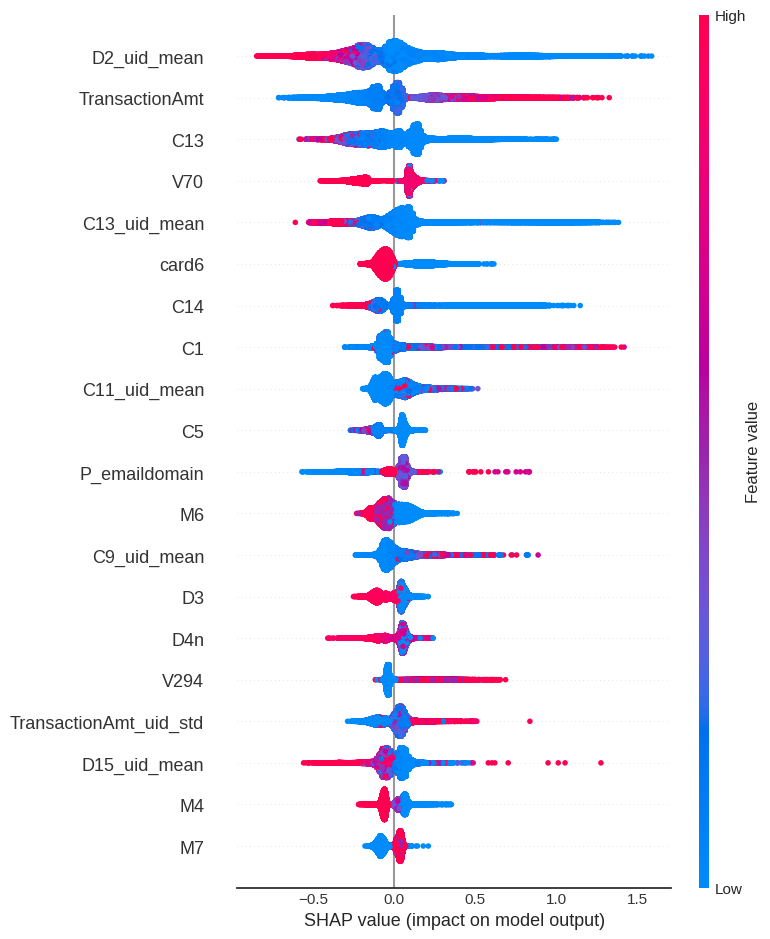

In [80]:
# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for validation data
shap_values = explainer.shap_values(x_train.loc[idx_validation, cols])

# SHAP summary plot to show global importance of features
shap.summary_plot(shap_values, x_train.loc[idx_validation, cols])


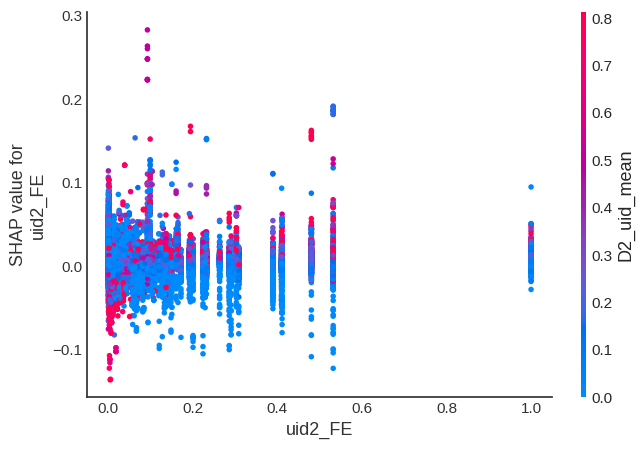

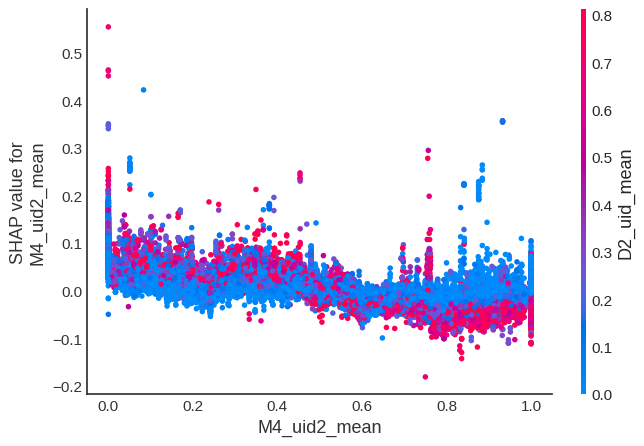

In [81]:
# SHAP dependence plot for 'uid2_FE'
shap.dependence_plot('uid2_FE', shap_values, x_train.loc[idx_validation, cols])

# SHAP dependence plot for 'M4_uid2_mean'
shap.dependence_plot('M4_uid2_mean', shap_values, x_train.loc[idx_validation, cols])
